# Addition experiment

An implementation of sequence to sequence learning for performing addition

* Input: "535+61"

* Output: "596"

Padding is handled by using a repeated sentinel character (space)
Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits inverted:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits inverted:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits inverted:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits inverted:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs

In [1]:
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'C:\\Users\\tumanov\\AppData\\Local\\Temp\\try_flags__ck3yvy_.c:4:19: fatal error: cudnn.h: No such file or directory\r\ncompilation terminated.\r\n'
Mapped name None to device cuda0: GeForce GTX 1070 (0000:01:00.0)


## Utils

In [2]:
def non_trainable(net):
    for tags in net.params.values():
        tags -= {'trainable', 'regularizable'}
    return net

## Parameters

In [3]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = True

In [4]:
# Try replacing GRU, or SimpleRNN.
HIDDEN_SIZE = 128

## Generating data

In [5]:
def generate_data(size, digits, problem = lambda a, b: a+b, problem_operator='{}+{}'):
    source_seqs = []
    target_seqs = []
    seen = set()
    print('Generating data...')
    while len(source_seqs) < TRAINING_SIZE:
        f = lambda: int(''.join(np.random.choice(list('0123456789'))
                        for i in range(np.random.randint(1, DIGITS + 1))))
        a, b = f(), f()
        # Skip any addition questions we've already seen
        # Also skip any such that x+Y == Y+x (hence the sorting).
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        # Pad the data with spaces such that it is always MAXLEN.
        q = problem_operator.format(a, b)
        ans = str(problem(a, b))

        source_seqs.append(q)
        target_seqs.append(["START"] + list(ans) + ["END"])

    print('Total addition questions:', len(source_seqs))
    
    target_letters = list(set([token for ts in target_seqs for token in ts]))
    target_letter_to_ix = {ph:i for i,ph in enumerate(target_letters)}
    
    source_letters = list(set([token for word in source_seqs for token in word]))
    source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}
    
    return np.array(source_seqs), source_letters, source_letter_to_ix, \
           np.array(target_seqs), target_letters, target_letter_to_ix

In [6]:
source_seqs, source_letters, source_letter_to_ix, target_seqs, target_letters, target_letter_to_ix =\
                    generate_data(TRAINING_SIZE, DIGITS)

Generating data...
Total addition questions: 50000


In [7]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

929+19 : 948
682+80 : 762
673+282 : 955
13+3 : 16
50+23 : 73


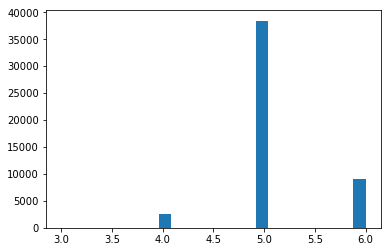

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,target_seqs)),bins=25);

# Truncate names longer than MAX_LEN characters. This can be changed
MAX_LEN = min([150,max(list(map(len, target_seqs)))])

## Cast everything from symbols into matrix of int32. Pad with -1

In [9]:
def as_matrix(sequences, token_to_i, max_len=None, PAX_ix=-1):
    """
    Converts several sequences of tokens to a matrix, edible a neural network.
    Crops at max_len(if given), pads shorter sequences with -1 or PAD_ix.
    """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int8') -1
    for i,seq in enumerate(sequences):
        
        row_ix = [token_to_i.get(_, 0) for _ in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


## Input vars

In [10]:
input_sequence = T.matrix('token sequence', 'int32')
output_sequence = T.matrix('target target_letters', 'int32')

## Classic model

In [11]:

##ENCODER
l_in = InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1)) 


l_emb = non_trainable(EmbeddingLayer(l_in, len(source_letters),  len(source_letters), W=np.diag(np.ones(len(source_letters)))))
l_rnn = LSTMLayer(l_emb, HIDDEN_SIZE, only_return_final=True, mask_input=l_mask)

In [12]:
##DECODER
dec_in = InputLayer(shape=(None, None),input_var=output_sequence)
dec_mask = InputLayer(shape=(None, None),input_var=T.neq(output_sequence,-1))

dec_emb = non_trainable(EmbeddingLayer(dec_in, len(target_letters), len(target_letters), W=np.diag(np.ones(len(target_letters)))))
dec_rnn = LSTMLayer(dec_emb, num_units=HIDDEN_SIZE, cell_init=l_rnn, mask_input=dec_mask)
# WARNING! if it's lstm use cell_init, not hid_init


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)

In [13]:
def handle_model(nn, learning_rate=0.001):
    # Model weights
    weights = get_all_params(nn)
    network_output = get_output(nn)
    network_output = network_output.reshape([output_sequence.shape[0],\
                                         output_sequence.shape[1], -1])
    predictions_flat = network_output[:,:-1,:].reshape([-1,len(target_letters)])
    targets = output_sequence[:,1:].ravel()

    #do not count loss for '-1' tokens
    mask = T.nonzero(T.neq(targets,-1))

    loss = lasagne.objectives.categorical_crossentropy(predictions_flat[mask], targets[mask]).mean()
    updates = lasagne.updates.adam(loss, weights, learning_rate=learning_rate)
    #training
    train = theano.function([input_sequence, output_sequence], loss, updates=updates, allow_input_downcast=True)

    #computing loss without training
    compute_cost = theano.function([input_sequence, output_sequence], loss, allow_input_downcast=True)
    #compile the function that computes probabilities for next token given previous text.

    last_probas =network_output[:, -1]

    probs = theano.function([input_sequence, output_sequence], last_probas)
    return train, compute_cost, probs

In [14]:
train, compute_cost, probs = handle_model(l_out)

# Generation

We now need to implement a function that generates output sequence given input.

Such function must work thusly:
```
Init:
x = input
y = ["START"]

While not_too_long:
  p(y_next|x,y) = probabilities of next letter for y
  
  y_next ~ p(y_next|x,y)
  
  y.append(y_next)
  
  if y_next == "END":
      break
```

In [15]:
def generate_output(input, probs, target_letters, target_letter_to_ix, source_letter_to_ix,
                    output_prefix = ("START",),
                    END_token="END",
                    temperature=1,
                    sample=True):
    
    """
    Implement a function that generates output sequence given input.
    
    We recommend (but not require) you to use the pseudo-code above and inline instructions.
    """
    x = as_matrix([input], source_letter_to_ix) 
    output = list(output_prefix)
    while True:
        y = as_matrix([output], target_letter_to_ix)
        next_y_probs = probs(x, y)
        next_y_probs = (next_y_probs ** temperature) / (next_y_probs ** temperature).sum()
        if sample:
            next_y = np.random.choice(target_letters, p=next_y_probs[0])
        else:
            next_y = target_letters[next_y_probs[0].argmax()]
        next_y = str(next_y)             
        assert type(next_y) is str, "please return token(string/character), not it's index"
        
        output.append(next_y)

        if next_y==END_token:
            break
            
    return output



## Model training

In [16]:
#source_seqs = np.array(source_seqs)
#target_seqs = np.array(target_seqs)

In [17]:
def sample_batch(source_seqs, source_letter_to_ix, target_seqs, target_letter_to_ix, batch_size):
    """samples a random batch of source and target sequences, batch_size elements"""
    batch_ix = np.random.randint(0,len(source_seqs),size=batch_size)
    source_seqs_batch=as_matrix(source_seqs[batch_ix], source_letter_to_ix) 
    target_seqs_batch=as_matrix(target_seqs[batch_ix], target_letter_to_ix)
    
    return source_seqs_batch,target_seqs_batch

In [21]:
#total N iterations
n_epochs=30

# how many minibatches are there in the epoch 
train_batches_per_epoch = 500
val_batches_per_epoch = 50

#how many training sequences are processed in a single function call
batch_size=64


train_source_seqs, val_source_seqs, train_target_seqs, val_target_seqs = train_test_split(source_seqs, target_seqs,\
                                                                                          test_size=0.33, random_state=42)

for epoch in range(n_epochs):
    try:

        train_avg_cost = 0;
        val_avg_cost = 0;

        for _ in range(train_batches_per_epoch):
            x,y = sample_batch(train_source_seqs, source_letter_to_ix, train_target_seqs, target_letter_to_ix, batch_size)
            train_avg_cost += train(x, y).mean()
        
        for _ in range(val_batches_per_epoch):
            x,y = sample_batch(val_source_seqs, source_letter_to_ix, val_target_seqs, target_letter_to_ix, batch_size)
            val_avg_cost += compute_cost(x, y).mean()

        print("Epoch {} train average loss = {}".format(epoch, train_avg_cost / train_batches_per_epoch))
        print("Epoch {} val average loss = {}".format(epoch, val_avg_cost / val_batches_per_epoch))
        
        for i in range(5):
            ind = np.random.randint(len(val_source_seqs))
            print (val_source_seqs[ind],':', ''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]),' | ', ''.join(val_target_seqs[ind][1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 train average loss = 0.08197419669138639
Epoch 0 val average loss = 0.11527614729696303
59+996 : 1055  |  1055
534+873 : 1397  |  1407
267+31 : 308  |  298
5+515 : 520  |  520
388+9 : 407  |  397
Epoch 1 train average loss = 0.07638746983330547
Epoch 1 val average loss = 0.11739519589507472
272+5 : 277  |  277
716+37 : 753  |  753
681+81 : 762  |  762
547+75 : 622  |  622
29+857 : 886  |  886
Epoch 2 train average loss = 0.07240082069820562
Epoch 2 val average loss = 0.12240237601262764
416+0 : 416  |  416
803+670 : 1483  |  1473
485+0 : 485  |  485
97+406 : 503  |  503
366+991 : 1357  |  1357
Epoch 3 train average loss = 0.06832969206544318
Epoch 3 val average loss = 0.09738800715904881
924+232 : 1046  |  1156
336+578 : 914  |  914
798+963 : 1761  |  1761
37+964 : 1001  |  1001
549+66 : 615  |  615
Epoch 4 train average loss = 0.06131126798776717
Epoch 4 val average loss = 0.09616244593585298
167+24 : 191  |  191
62+89 : 151  |  151
646+270 : 906  |  916
1+952 : 953  |  953
48

## Bazal module

In [22]:
class CerMemory(lasagne.layers.Layer):
    def __init__(self, incoming, memory_size, M=lasagne.init.Orthogonal(), **kwargs):
        super(CerMemory, self).__init__(incoming, **kwargs)
        self.query_shape = self.input_shape[1]
        self.memory_size = memory_size
        self.M = self.add_param(M, (self.query_shape, memory_size), name='M')

    def get_output_for(self, input, **kwargs):
        m = self.M / T.sqrt(T.sqr(self.M).sum(axis=0)).reshape(self.M.shape[1], 1)
        weights =  T.dot(input, m)
        return T.dot(weights, m.T)
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.query_shape)

In [23]:
class EvcNormalizer(lasagne.layers.Layer):
    def get_output_for(self, input, **kwargs):
        return (input.T / T.sqrt(T.sqr(input).sum(axis=1)).reshape(input.shape[0], 1)).T

In [24]:
QUERY_SIZE = 16
MEMORY_SIZE = 64
HIDDEN_SIZE = 128

In [25]:
def bazal_model(query_size, memory_size, hidden_size, memory_benchmark=False):

    ##ENCODER
    l_in = InputLayer(shape=(None, None),input_var=input_sequence)
    l_mask = InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1)) 


    l_emb = non_trainable(EmbeddingLayer(l_in, len(source_letters),  len(source_letters), W=np.diag(np.ones(len(source_letters)))))
    features = LSTMLayer(l_emb, HIDDEN_SIZE, only_return_final=True, mask_input=l_mask)
    
    if not memory_benchmark:
        ## QUERY BUILDER
        query = DenseLayer(features, QUERY_SIZE, nonlinearity=None)
        query = EvcNormalizer(query)
        ## Memory
        memory = CerMemory(query, MEMORY_SIZE)
    else:
        memory = DenseLayer(DenseLayer(features, QUERY_SIZE), QUERY_SIZE)
        
    to_decode = ConcatLayer([features, memory])
    
    ##DECODER
    dec_in = InputLayer(shape=(None, None),input_var=output_sequence)
    dec_mask = InputLayer(shape=(None, None),input_var=T.neq(output_sequence,-1))

    dec_emb = non_trainable(EmbeddingLayer(dec_in, len(target_letters), len(target_letters), W=np.diag(np.ones(len(target_letters)))))
    dec_rnn = LSTMLayer(dec_emb, num_units=to_decode.output_shape[-1], cell_init=to_decode, mask_input=dec_mask)
    # WARNING! if it's lstm use cell_init, not hid_init


    #flatten batch and time to be compatible with feedforward layers (will un-flatten later)
    dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

    l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)
    return l_out, memory

In [26]:
l_out, memory = bazal_model(QUERY_SIZE, MEMORY_SIZE, HIDDEN_SIZE, False)

In [27]:
train, compute_cost, probs = handle_model(l_out)

In [28]:
#total N iterations
n_epochs=30

# how many minibatches are there in the epoch 
train_batches_per_epoch = 500
val_batches_per_epoch = 50

#how many training sequences are processed in a single function call
batch_size=64


train_source_seqs, val_source_seqs, train_target_seqs, val_target_seqs = train_test_split(source_seqs, target_seqs,\
                                                                                          test_size=0.33, random_state=42)

for epoch in range(n_epochs):
    try:

        train_avg_cost = 0;
        val_avg_cost = 0;

        for _ in range(train_batches_per_epoch):
            x,y = sample_batch(train_source_seqs, source_letter_to_ix, train_target_seqs, target_letter_to_ix, batch_size)
            train_avg_cost += train(x, y).mean()
        
        for _ in range(val_batches_per_epoch):
            x,y = sample_batch(val_source_seqs, source_letter_to_ix, val_target_seqs, target_letter_to_ix, batch_size)
            val_avg_cost += compute_cost(x, y).mean()

        print("Epoch {} train average loss = {}".format(epoch, train_avg_cost / train_batches_per_epoch))
        print("Epoch {} val average loss = {}".format(epoch, val_avg_cost / val_batches_per_epoch))
        
        for i in range(5):
            ind = np.random.randint(len(val_source_seqs))
            print (val_source_seqs[ind],':', ''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]),' | ', ''.join(val_target_seqs[ind][1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 train average loss = 1.703139966258563
Epoch 0 val average loss = 1.5361868813827226
16+192 : 616  |  208
383+915 : 1500  |  1298
552+38 : 778  |  590
201+179 : 958  |  380
26+244 : 380  |  270
Epoch 1 train average loss = 1.3784032784319356
Epoch 1 val average loss = 1.2626754988447817
565+978 : 1508  |  1543
439+47 : 548  |  486
853+534 : 1850  |  1387
2+476 : 663  |  478
656+7 : 660  |  663
Epoch 2 train average loss = 1.18885158952572
Epoch 2 val average loss = 1.1272228235305186
891+84 : 957  |  975
3+260 : 223  |  263
485+49 : 537  |  534
80+667 : 752  |  747
98+45 : 139  |  143
Epoch 3 train average loss = 1.068614112183761
Epoch 3 val average loss = 1.0230188550521002
772+97 : 860  |  869
194+162 : 338  |  356
136+15 : 105  |  151
917+79 : 1016  |  996
349+344 : 798  |  693
Epoch 4 train average loss = 0.9727485846004202
Epoch 4 val average loss = 0.9426264083779726
559+844 : 1427  |  1403
825+93 : 886  |  918
267+76 : 356  |  343
698+9 : 794  |  707
985+3 : 959  |  988

In [41]:
M_add = np.array(memory.M.eval())

In [43]:
np.save('./zoo/addprob_memory_after30epochs.npy', M_add)

## Same for prod problem

In [29]:
TRAINING_SIZE = 100000
DIGITS = 3

In [30]:
source_seqs, source_letters, source_letter_to_ix, target_seqs, target_letters, target_letter_to_ix =\
                    generate_data(TRAINING_SIZE, DIGITS, lambda a, b: a * b, '{}*{}')

Generating data...
Total addition questions: 100000


In [31]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

8*81 : 648
2*90 : 180
6*45 : 270
6*59 : 354
1*83 : 83


In [32]:
QUERY_SIZE = 16
MEMORY_SIZE = 64
HIDDEN_SIZE = 128

In [33]:
l_out, memory = bazal_model(QUERY_SIZE, MEMORY_SIZE, HIDDEN_SIZE,  False)

In [34]:
train, compute_cost, probs = handle_model(l_out, 0.001)

In [258]:
#total N iterations
n_epochs=1000

# how many minibatches are there in the epoch 
train_batches_per_epoch = 500
val_batches_per_epoch = 50

#how many training sequences are processed in a single function call
batch_size=128


train_source_seqs, val_source_seqs, train_target_seqs, val_target_seqs = train_test_split(source_seqs, target_seqs,\
                                                                                          test_size=0.33, random_state=42)

for epoch in range(n_epochs):
    try:

        train_avg_cost = 0;
        val_avg_cost = 0;

        for _ in range(train_batches_per_epoch):
            x,y = sample_batch(train_source_seqs, source_letter_to_ix, train_target_seqs, target_letter_to_ix, batch_size)
            train_avg_cost += train(x, y).mean()
        
        for _ in range(val_batches_per_epoch):
            x,y = sample_batch(val_source_seqs, source_letter_to_ix, val_target_seqs, target_letter_to_ix, batch_size)
            val_avg_cost += compute_cost(x, y).mean()

        print("Epoch {} train average loss = {}".format(epoch, train_avg_cost / train_batches_per_epoch))
        print("Epoch {} val average loss = {}".format(epoch, val_avg_cost / val_batches_per_epoch))
        
        for i in range(5):
            ind = np.random.randint(len(val_source_seqs))
            print (val_source_seqs[ind],':', ''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]),' | ', ''.join(val_target_seqs[ind][1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 train average loss = 0.4745134306164804
Epoch 0 val average loss = 0.5041249347773323
269*629 : 170221  |  169201
590*943 : 558570  |  556370
714*80 : 57240  |  57120
69*852 : 58768  |  58788
38*897 : 34214  |  34086
Epoch 1 train average loss = 0.47013104617667933
Epoch 1 val average loss = 0.49574675095872833
0*561 : 0  |  0
24*894 : 21296  |  21456
104*71 : 7504  |  7384
317*780 : 243860  |  247260
96*949 : 89904  |  91104
Epoch 2 train average loss = 0.46767226161750364
Epoch 2 val average loss = 0.5003663286992424
269*37 : 9963  |  9953
627*618 : 389326  |  387486
46*67 : 3082  |  3082
472*73 : 34216  |  34456
653*4 : 2612  |  2612
Epoch 3 train average loss = 0.4647098757192144
Epoch 3 val average loss = 0.4996647706121669
213*638 : 135754  |  135894
235*681 : 158895  |  160035
387*865 : 332905  |  334755
87*915 : 79735  |  79605
332*45 : 15040  |  14940
Epoch 4 train average loss = 0.4655186190564228
Epoch 4 val average loss = 0.49633644803236115
169*9 : 1521  |  1521
21

## Grand problem

In [215]:
prob1, prob_op1 = lambda a, b, c: (a + b) * c, '({}+{})*{}'
prob2, prob_op2 = lambda a, b, c:  a * (b + c), '{}*({}+{})'
prob3, prob_op3 = lambda a, b, c:  a + b * c, '{}+{}*{}'
prob4, prob_op4 = lambda a, b, c:  a * b + c, '{}*{}+{}'

In [216]:
def generate_grand_data(size, digits, problems = [prob1, prob2, prob3, prob4],\
                        problem_operators=[prob_op1, prob_op2, prob_op3, prob_op4]):
    source_seqs = []
    target_seqs = []
    seen = set()
    assert len(problem_operators) == len(problems)
    print('Generating data...')
    while len(source_seqs) < TRAINING_SIZE:
        f = lambda: int(''.join(np.random.choice(list('0123456789'))
                        for i in range(np.random.randint(1, DIGITS + 1))))
        a, b, c = f(), f(), f()
        # Skip any addition questions we've already seen
        # Also skip any such that x+Y == Y+x (hence the sorting).
        key = tuple(sorted((a, b, c)))
        if key in seen:
            continue
        seen.add(key)
        
        coin = np.random.randint(0, len(problems))
        
        # Pad the data with spaces such that it is always MAXLEN.
        q = problem_operators[coin].format(a, b, c)
        ans = str(problems[coin](a, b, c))

        source_seqs.append(q)
        target_seqs.append(["START"] + list(ans) + ["END"])

    print('Total addition questions:', len(source_seqs))
    
    target_letters = list(set([token for ts in target_seqs for token in ts]))
    target_letter_to_ix = {ph:i for i,ph in enumerate(target_letters)}
    
    source_letters = list(set([token for word in source_seqs for token in word]))
    source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}
    
    return np.array(source_seqs), source_letters, source_letter_to_ix, \
           np.array(target_seqs), target_letters, target_letter_to_ix

In [217]:
TRAINING_SIZE = 2000
DIGITS = 2

In [218]:
source_seqs, source_letters, source_letter_to_ix, target_seqs, target_letters, target_letter_to_ix =\
                    generate_grand_data(TRAINING_SIZE, DIGITS)

Generating data...
Total addition questions: 2000


In [219]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

93+3*79 : 330
2*0+30 : 30
1*(73+45) : 118
6*(3+67) : 420
69*8+3 : 555


In [220]:
QUERY_SIZE = 16
MEMORY_SIZE = 64
HIDDEN_SIZE = 128

In [221]:
l_out, memory = bazal_model(QUERY_SIZE, MEMORY_SIZE, HIDDEN_SIZE,  False)

In [222]:
train, compute_cost, probs = handle_model(l_out)

In [223]:
#total N iterations
n_epochs=30

# how many minibatches are there in the epoch 
train_batches_per_epoch = 500
val_batches_per_epoch = 50

#how many training sequences are processed in a single function call
batch_size=64


train_source_seqs, val_source_seqs, train_target_seqs, val_target_seqs = train_test_split(source_seqs, target_seqs,\
                                                                                          test_size=0.33, random_state=42)

for epoch in range(n_epochs):
    try:

        train_avg_cost = 0;
        val_avg_cost = 0;

        for _ in range(train_batches_per_epoch):
            x,y = sample_batch(train_source_seqs, source_letter_to_ix, train_target_seqs, target_letter_to_ix, batch_size)
            train_avg_cost += train(x, y).mean()
        
        for _ in range(val_batches_per_epoch):
            x,y = sample_batch(val_source_seqs, source_letter_to_ix, val_target_seqs, target_letter_to_ix, batch_size)
            val_avg_cost += compute_cost(x, y).mean()

        print("Epoch {} train average loss = {}".format(epoch, train_avg_cost / train_batches_per_epoch))
        print("Epoch {} val average loss = {}".format(epoch, val_avg_cost / val_batches_per_epoch))
        
        for i in range(5):
            ind = np.random.randint(len(val_source_seqs))
            print (val_source_seqs[ind],':', ''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]),' | ', ''.join(val_target_seqs[ind][1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 average loss = 1.8074171794116005
3*(54+8) : 839  |  186
44*7+7 : 229  |  315
57+15*4 : 218  |  117
43*1+2 : 108  |  45
27*2+87 : 608  |  141
Epoch 1 average loss = 1.6196723853008468
18+7*62 : 303  |  452
48+7*4 : 98  |  76
8+89*8 : 403  |  720
2*(59+96) : 269  |  310
(58+6)*8 : 880  |  512
Epoch 2 average loss = 1.4874540646206253
92+53*92 : 5099  |  4968
(78+75)*87 : 7765  |  13311
54*(25+0) : 1452  |  1350
(1+0)*64 : 40  |  64
0*7+1 : 3  |  1
Epoch 3 average loss = 1.3032164222313742
97*(3+18) : 2709  |  2037
57*39+80 : 4453  |  2303
74*4+7 : 359  |  303
0*(78+6) : 0  |  0
(87+7)*48 : 2318  |  4512
Epoch 4 average loss = 1.0245313576234003
7*8+75 : 103  |  131
6+6*93 : 469  |  564
1+61*5 : 419  |  306
2+59*30 : 2598  |  1772
39*42+95 : 1373  |  1733
Epoch 5 average loss = 0.6894229277183287
74*(2+60) : 1428  |  4588
9*6+23 : 79  |  77
47*(49+2) : 4234  |  2397
7+8*5 : 30  |  47
2*69+98 : 208  |  236
Epoch 6 average loss = 0.4108774484056355
1+20*0 : 4  |  1
15*44+65 : 320  